In [1]:
# Install PyTorch Geometric & dependensinya untuk Colab
!pip install torch==2.0.0+cu118 torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
!pip install torch-scatter -f https://data.pyg.org/whl/torch-2.0.0+cu118.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-2.0.0+cu118.html
!pip install torch-cluster -f https://data.pyg.org/whl/torch-2.0.0+cu118.html
!pip install torch-spline-conv -f https://data.pyg.org/whl/torch-2.0.0+cu118.html
!pip install torch-geometric
!pip install pandas scikit-learn matplotlib
!pip install seaborn

# Downgrade NumPy ke versi stabil 1.x untuk kompatibilitas
!pip install numpy==1.24.4



Looking in indexes: https://download.pytorch.org/whl/cu118
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 GB 1.7 MB/s eta 0:00:000:00:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 70.7 MB/s eta 0:00:00:00:010:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 56.2 MB/s eta 0:00:00:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 94.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.3/133.3 KB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.3/63.3 MB 34.7 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.2/6.2 MB 63.1 MB/s eta 0:00:00a 0:00:01m
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.3/132.3 KB 45.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 57.8 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 69.4 MB/s eta 0:00:00:00:010:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
import pandas as pd
import torch
import torch.nn.functional as F
from torch_geometric.data import Dataset, Data
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GCNConv, global_mean_pool
import ast


In [3]:
class CSVGraphDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        self.df = pd.read_csv(csv_file)
        self.df["Node_Features"] = self.df["Node_Features"].apply(ast.literal_eval)
        self.df["Edge_Index"] = self.df["Edge_Index"].apply(ast.literal_eval)
        self.label_map = {"tidak_estetik": 0, "estetik": 1}
        self.transform = transform
        super().__init__()

    def len(self):
        return len(self.df)

    def get(self, idx):
        row = self.df.iloc[idx]
        x = torch.tensor(row["Node_Features"], dtype=torch.float)
        edge_index = torch.tensor(row["Edge_Index"], dtype=torch.long)
        if edge_index.shape[0] != 2:
            edge_index = edge_index.t().contiguous()
        y = torch.tensor(self.label_map[row["Category"]], dtype=torch.long)
        data = Data(x=x, edge_index=edge_index, y=y)
        data.file_name = row["Filename"]
        return self.transform(data) if self.transform else data


In [3]:
class PTGraphDataset(Dataset):
    def __init__(self, pt_file, transform=None):
        self.data_list = torch.load(pt_file)
        self.transform = transform
        super().__init__()

    def len(self):
        return len(self.data_list)

    def get(self, idx):
        data = self.data_list[idx]
        return self.transform(data) if self.transform else data

In [14]:
!pip install gdown


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 187.3/187.3 KB 16.7 MB/s eta 0:00:00


In [18]:
import gdown

# Ganti ini dengan ID file dari link berbagi Google Drive
file_id = '11fWwNoHiEI3JUtbHaG_cGVJA98zixn7R'
output = 'test_graph.pt'  # Ganti sesuai nama file yang diinginkan
gdown.download(f'https://drive.google.com/uc?id={file_id}', output, quiet=False)


Downloading...
From (original): https://drive.google.com/uc?id=11fWwNoHiEI3JUtbHaG_cGVJA98zixn7R
From (redirected): https://drive.google.com/uc?id=11fWwNoHiEI3JUtbHaG_cGVJA98zixn7R&confirm=t&uuid=c6f6d1d6-1d30-4e81-9330-924528120524
To: /workspace/test_graph.pt
100%|██████████| 46.8M/46.8M [00:00<00:00, 85.6MB/s]


'test_graph.pt'

In [ ]:
import pandas as pd
df = pd.read_csv("/content/drive/MyDrive/Hasil_Ekstraksi/graph_dataset_fresh.csv")

# Cek baris yang tidak bisa dieval
import ast

def is_valid_literal(x):
    try:
        ast.literal_eval(x)
        return True
    except:
        return False

invalid_rows = df[~df["Node_Features"].apply(is_valid_literal)]
print("Jumlah baris bermasalah:", len(invalid_rows))
print(invalid_rows[["Filename", "Node_Features"]].head())


In [ ]:
print(invalid_rows["Filename"].tolist())


In [ ]:
import pandas as pd

# Path file CSV lama
csv_path = "/content/drive/MyDrive/Hasil_Ekstraksi/graph_dataset_fresh.csv"

# Daftar filename yang ingin dihapus
hapus_list = [
    '18650.jpg', '22236.jpg', '1524.jpg', '2663.jpg', '3660.jpg',
    '4873.jpg', '5406.jpg', '5847.jpg', '6737.jpg', '9981.jpg'
]

# Baca CSV lama
df = pd.read_csv(csv_path)

# Filter baris yang tidak termasuk file yang akan dihapus
df_bersih = df[~df["Filename"].isin(hapus_list)]

# Simpan ulang ke file asli
df_bersih.to_csv(csv_path, index=False)

print(f"✅ File berhasil diperbarui dan disimpan kembali ke:\n{csv_path}")
print(f"📊 Total baris setelah dibersihkan: {len(df_bersih)}")


In [ ]:
from torch_geometric.data import InMemoryDataset, Data
import torch

# Praproses CSV menjadi daftar Data
data_list = []
for row in pd.read_csv("graph_dataset_fresh_1.csv", chunksize=10000):
    for i in range(len(row)):
        data = row_to_graph(row.iloc[i])
        data_list.append(data)

torch.save(data_list, "processed_graphs.pt")


In [4]:
dataset = PTGraphDataset("processed_graphs_pca_fix.pt")


train_loader = DataLoader(dataset, batch_size=10, shuffle=True)
print(f"Total graph: {len(dataset)}")



Total graph: 24000


In [19]:

train_data = torch.load("train_graph.pt")
test_data = torch.load("test_graph.pt")

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)


In [5]:



sample = dataset[1881]
print("x shape:", sample.x.shape)
print("edge_index shape:", sample.edge_index.shape)
print("y:", sample.y)


x shape: torch.Size([9, 512])
edge_index shape: torch.Size([2, 12])
y: tensor(0)


In [ ]:
print(self.df.columns)  # akan tampil: Index(['Filename', 'Node_Features', ...])


In [ ]:
# Cek label dari semua graph
from collections import Counter

all_labels = [dataset[i].y.item() for i in range(len(dataset))]
print("🔢 Jumlah label per kelas:")
print(Counter(all_labels))

# Atau tampilkan semua:
print("📋 Semua label di dataset:")
print(all_labels)


In [6]:
class GCNGraphClassifier(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, num_classes):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.lin = torch.nn.Linear(hidden_channels, num_classes)

    def forward(self, x, edge_index, batch):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = global_mean_pool(x, batch)  # [num_graphs, hidden_channels]
        return self.lin(x)              # [num_graphs, num_classes]

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool

class GCNGraphClassifier(nn.Module):
    def __init__(self, input_dim=2800, hidden_dim=128, num_classes=2):
        super(GCNGraphClassifier, self).__init__()

        self.gcn1 = GCNConv(input_dim, hidden_dim)
        self.gcn2 = GCNConv(hidden_dim, hidden_dim)
        self.dropout = nn.Dropout(p=0.3)
        self.classifier = nn.Linear(hidden_dim, num_classes)

    def forward(self, x, edge_index, batch):
        x = self.gcn1(x, edge_index)
        x = F.relu(x)
        x = self.dropout(x)

        x = self.gcn2(x, edge_index)
        x = F.relu(x)

        x = global_mean_pool(x, batch)  # agregasi semua node dalam graf
        out = self.classifier(x)
        return out


In [7]:
# Pastikan class GCNGraphClassifier sudah didefinisikan sebelum ini
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Ambil 1 sampel dari dataset untuk inisialisasi model
sample = dataset[0]

# Inisialisasi model
model = GCNGraphClassifier(sample.num_node_features, 64, 2).to(device)

# Optimizer dan loss
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()


In [20]:
for epoch in range(1, 101):
    model.train()
    total_loss = 0

    for batch in train_loader:
        batch = batch.to(device)
        optimizer.zero_grad()
        out = model(batch.x, batch.edge_index, batch.batch)
        loss = criterion(out, batch.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"[Epoch {epoch}] Train Loss: {total_loss / len(train_loader):.4f}")


[Epoch 1] Train Loss: 0.0818
[Epoch 2] Train Loss: 0.0630
[Epoch 3] Train Loss: 0.0567
[Epoch 4] Train Loss: 0.0564
[Epoch 5] Train Loss: 0.0586
[Epoch 6] Train Loss: 0.0582
[Epoch 7] Train Loss: 0.0618
[Epoch 8] Train Loss: 0.0533
[Epoch 9] Train Loss: 0.0761
[Epoch 10] Train Loss: 0.0626
[Epoch 11] Train Loss: 0.0585
[Epoch 12] Train Loss: 0.0602
[Epoch 13] Train Loss: 0.0535
[Epoch 14] Train Loss: 0.0634
[Epoch 15] Train Loss: 0.0509
[Epoch 16] Train Loss: 0.0592
[Epoch 17] Train Loss: 0.0656
[Epoch 18] Train Loss: 0.0527
[Epoch 19] Train Loss: 0.0559
[Epoch 20] Train Loss: 0.0524
[Epoch 21] Train Loss: 0.0507
[Epoch 22] Train Loss: 0.0877
[Epoch 23] Train Loss: 0.0633
[Epoch 24] Train Loss: 0.0565
[Epoch 25] Train Loss: 0.0512
[Epoch 26] Train Loss: 0.0677
[Epoch 27] Train Loss: 0.0588
[Epoch 28] Train Loss: 0.0480
[Epoch 29] Train Loss: 0.0589
[Epoch 30] Train Loss: 0.0562
[Epoch 31] Train Loss: 0.0621
[Epoch 32] Train Loss: 0.0797
[Epoch 33] Train Loss: 0.0507
[Epoch 34] Train Lo

🔎 Evaluasi Data Testing
Accuracy : 0.9675
F1 Score : 0.9695
Confusion Matrix:
 [[1081    8]
 [  70 1241]]


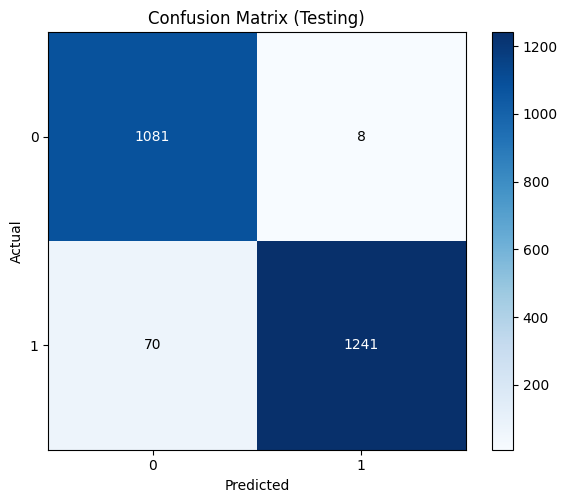

In [22]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

model.eval()
all_preds = []
all_labels = []
all_file_names = []

with torch.no_grad():
    for batch in test_loader:
        batch = batch.to(device)
        out = model(batch.x, batch.edge_index, batch.batch)
        preds = out.argmax(dim=1).cpu()
        labels = batch.y.cpu()

        # Ambil nama file jika ada
        try:
            data_list = batch.to_data_list()
            file_names = [d.file_name if hasattr(d, 'file_name') else f"G_{i}" for i, d in enumerate(data_list)]
        except:
            file_names = [f"G_{i}" for i in range(len(labels))]

        all_preds.extend(preds.tolist())
        all_labels.extend(labels.tolist())
        all_file_names.extend(file_names)

# Hitung metrik akhir
acc = accuracy_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds, average='binary')
cm = confusion_matrix(all_labels, all_preds)

print("🔎 Evaluasi Data Testing")
print(f"Accuracy : {acc:.4f}")
print(f"F1 Score : {f1:.4f}")
print("Confusion Matrix:\n", cm)

# Simpan gambar confusion matrix
plt.figure(figsize=(6, 5))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix (Testing)")
plt.colorbar()
tick_marks = np.arange(len(set(all_labels)))
plt.xticks(tick_marks, tick_marks)
plt.yticks(tick_marks, tick_marks)

thresh = cm.max() / 2.
for i, j in np.ndindex(cm.shape):
    plt.text(j, i, format(cm[i, j], 'd'),
             ha="center", va="center",
             color="white" if cm[i, j] > thresh else "black")

plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.tight_layout()
plt.savefig("confusion_matrix_test.png")
plt.show()


In [15]:
import os
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

log_dir = "logs"
os.makedirs(log_dir, exist_ok=True)

for epoch in range(1, 101):
    model.train()
    total_loss = 0

    all_preds = []
    all_labels = []
    all_file_names = []

    for batch in train_loader:
        batch = batch.to(device)
        optimizer.zero_grad()
        out = model(batch.x, batch.edge_index, batch.batch)
        loss = criterion(out, batch.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        # Kumpulkan prediksi dan label
        out_cpu = out.detach().cpu()
        preds = out_cpu.argmax(dim=1)
        labels = batch.y.cpu()

        # Ambil nama file jika ada
        try:
            data_list = batch.to_data_list()
            file_names = [d.file_name if hasattr(d, 'file_name') else f"G_{i}" for i, d in enumerate(data_list)]
        except:
            file_names = [f"G_{i}" for i in range(len(labels))]

        all_preds.extend(preds.tolist())
        all_labels.extend(labels.tolist())
        all_file_names.extend(file_names)

    # Hitung metrik evaluasi
    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='macro')
    cm = confusion_matrix(all_labels, all_preds)

    # Logging ringkasan ke file
    log_file = os.path.join(log_dir, f"epoch_{epoch}.txt")
    with open(log_file, "w") as f:
        f.write(f"[Epoch {epoch}] Train Loss: {total_loss / len(train_loader):.4f}\n")
        f.write(f"Accuracy: {acc:.4f} | F1 Score: {f1:.4f}\n")
        f.write(f"Confusion Matrix:\n{cm}\n\n")
        for name, pred, label in zip(all_file_names, all_preds, all_labels):
            f.write(f"{name}: Pred = {pred}, Label = {label}\n")

    # Print ke console
    print(f"[Epoch {epoch}] Loss: {total_loss / len(train_loader):.4f} | Acc: {acc:.4f} | F1: {f1:.4f}")
    print(f"Confusion Matrix:\n{cm}")
    # Simpan prediksi dan label dari epoch terakhir (atau terbaik)
if epoch == 100:
    import pickle
    with open("final_preds.pkl", "wb") as f:
        pickle.dump({
            "preds": all_preds,
            "labels": all_labels,
            "file_names": all_file_names
        }, f)
    print("✅ Disimpan: final_preds.pkl")



[Epoch 1] Loss: 0.0970 | Acc: 0.9614 | F1: 0.9613
Confusion Matrix:
[[10867    43]
 [  884 12206]]
[Epoch 2] Loss: 0.0849 | Acc: 0.9601 | F1: 0.9600
Confusion Matrix:
[[10779   131]
 [  826 12264]]
[Epoch 3] Loss: 0.1142 | Acc: 0.9566 | F1: 0.9563
Confusion Matrix:
[[10401   509]
 [  532 12558]]
[Epoch 4] Loss: 0.0849 | Acc: 0.9614 | F1: 0.9613
Confusion Matrix:
[[10853    57]
 [  869 12221]]
[Epoch 5] Loss: 0.0825 | Acc: 0.9609 | F1: 0.9608
Confusion Matrix:
[[10822    88]
 [  850 12240]]
[Epoch 6] Loss: 0.0921 | Acc: 0.9620 | F1: 0.9619
Confusion Matrix:
[[10851    59]
 [  852 12238]]
[Epoch 7] Loss: 0.0985 | Acc: 0.9582 | F1: 0.9580
Confusion Matrix:
[[10761   149]
 [  855 12235]]
[Epoch 8] Loss: 0.0981 | Acc: 0.9562 | F1: 0.9560
Confusion Matrix:
[[10679   231]
 [  820 12270]]
[Epoch 9] Loss: 0.0854 | Acc: 0.9577 | F1: 0.9576
Confusion Matrix:
[[10727   183]
 [  831 12259]]
[Epoch 10] Loss: 0.1017 | Acc: 0.9534 | F1: 0.9532
Confusion Matrix:
[[10609   301]
 [  818 12272]]
[Epoch 11

In [13]:
!pip install seaborn


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 KB 5.9 MB/s eta 0:00:00a 0:00:01


🔎 Evaluasi Keseluruhan:
Accuracy : 0.9532
Precision: 0.9621
Recall   : 0.9517
F1 Score : 0.9569
Confusion Matrix:
 [[10419   491]
 [  632 12458]]


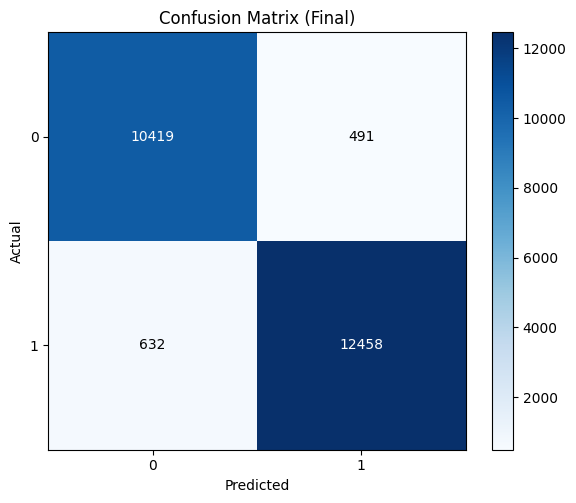

In [16]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Load hasil prediksi akhir
with open("final_preds.pkl", "rb") as f:
    data = pickle.load(f)

y_pred = data["preds"]
y_true = data["labels"]

# Hitung metrik evaluasi
acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred, average='binary')
rec = recall_score(y_true, y_pred, average='binary')
f1 = f1_score(y_true, y_pred, average='binary')
cm = confusion_matrix(y_true, y_pred)

# Cetak hasilnya
print("🔎 Evaluasi Keseluruhan:")
print(f"Accuracy : {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall   : {rec:.4f}")
print(f"F1 Score : {f1:.4f}")
print("Confusion Matrix:\n", cm)

# Gambar confusion matrix
plt.figure(figsize=(6, 5))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix (Final)")
plt.colorbar()

tick_marks = np.arange(len(set(y_true)))
plt.xticks(tick_marks, tick_marks)
plt.yticks(tick_marks, tick_marks)

# Tampilkan angka
thresh = cm.max() / 2.
for i, j in np.ndindex(cm.shape):
    plt.text(j, i, format(cm[i, j], 'd'),
             ha="center", va="center",
             color="white" if cm[i, j] > thresh else "black")

plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.tight_layout()
plt.savefig("confusion_matrix_final.png")
plt.show()


In [ ]:
import torch
from torch_geometric.loader import DataLoader
from torch.utils.data import random_split
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Setup device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Split dataset 80% train, 20% test
total = len(dataset)
train_size = int(0.8 * total)
test_size = total - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

# Inisialisasi model
sample = dataset[0]
model = GCNGraphClassifier(sample.num_node_features, 64, 2).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

train_losses = []
test_losses = []
eval_epochs = []
accs = []
precisions = []
recalls = []
f1s = []

# Training
for epoch in range(1, 101):
    model.train()
    total_train_loss = 0

    for batch in train_loader:
        batch = batch.to(device)
        optimizer.zero_grad()
        out = model(batch.x, batch.edge_index, batch.batch)
        loss = criterion(out, batch.y)
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()

    avg_train_loss = total_train_loss / len(train_loader)

    # Hitung test loss
    model.eval()
    total_test_loss = 0
    with torch.no_grad():
        for batch in test_loader:
            batch = batch.to(device)
            out = model(batch.x, batch.edge_index, batch.batch)
            loss = criterion(out, batch.y)
            total_test_loss += loss.item()
    avg_test_loss = total_test_loss / len(test_loader)

    # Simpan loss setiap 10 epoch
    if epoch % 10 == 0:
        train_losses.append(avg_train_loss)
        test_losses.append(avg_test_loss)

    # Evaluasi setiap 5 epoch
    if epoch % 5 == 0:
        model.eval()
        y_true = []
        y_pred = []
        misclassified_files = []

        with torch.no_grad():
            for batch in test_loader:
                batch = batch.to(device)
                out = model(batch.x, batch.edge_index, batch.batch)
                preds = out.argmax(dim=1).cpu()
                labels = batch.y.cpu()

                y_true.extend(labels.numpy())
                y_pred.extend(preds.numpy())

                # ⬅️ Tracking file yang salah prediksi
                if hasattr(batch, 'file_name'):  # cek apakah file_name tersedia
                    for i in range(len(preds)):
                        if preds[i] != labels[i]:
                            misclassified_files.append(batch.file_name[i])


        acc = accuracy_score(y_true, y_pred)
        prec = precision_score(y_true, y_pred, average='weighted', zero_division=0)
        rec = recall_score(y_true, y_pred, average='weighted', zero_division=0)
        f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)

        accs.append(acc)
        precisions.append(prec)
        recalls.append(rec)
        f1s.append(f1)
        eval_epochs.append(epoch)

        print(f"[Epoch {epoch}] Train Loss: {avg_train_loss:.4f} | Test Loss: {avg_test_loss:.4f}")
        print(f"           Acc: {acc:.4f} | Prec: {prec:.4f} | Recall: {rec:.4f} | F1: {f1:.4f}")
        if misclassified_files:
            print(f"  Salah prediksi ({len(misclassified_files)} graf):")
            for name in misclassified_files[:5]:  # tampilkan 5 contoh saja
                print(f"   - {name}")


# Plot loss
plt.figure(figsize=(10, 5))
plt.plot(range(10, 101, 10), train_losses, label='Train Loss', marker='o')
plt.plot(range(10, 101, 10), test_losses, label='Test Loss', marker='s')
plt.title('Loss per 10 Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot metrik evaluasi
plt.figure(figsize=(10, 6))
plt.plot(eval_epochs, accs, label='Accuracy', marker='o')
plt.plot(eval_epochs, precisions, label='Precision', marker='s')
plt.plot(eval_epochs, recalls, label='Recall', marker='^')
plt.plot(eval_epochs, f1s, label='F1-score', marker='d')
plt.title('Evaluasi Model Setiap 5 Epoch')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
out = model(batch.x, batch.edge_index, batch.batch)  # output mentah
probs = torch.softmax(out, dim=1)                    # ubah jadi probabilitas

# Ambil probabilitas kelas estetik (label = 1)
prob_estetik = probs[:, 1]  # shape [batch_size]

for i, prob in enumerate(prob_estetik):
    print(f"Graf ke-{i+1} → Estetik dengan kemungkinan {prob.item():.2%}")
